# Packages Notebook

Same as v3p1. except now plot packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor


%matplotlib inline

INFO:epimodel.regions:Name index has 7 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands', 'virgin islands (u.s.)']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   ... mean  ... max   ... unique
 1 Masks over 60                              0.000 ... 0.016 ... 1.000 ... [0. 1.]
 2 Asymptomatic contact isolation             0.000 ... 0.120 ... 1.000 ... [0. 1.]
 3 Gatherings limited to 10                   0.000 ... 0.153 ... 1.000 ... [0. 1.]
 4 Gatherings limited to 100                  0.000 ... 0.248 ... 1.000 ... [0. 1.]
 5 Gatherings limited to 1000                 0.000 ... 0.285 ... 1.000 ... [0. 1.]
 6 Business suspended - some                  0.000 ... 0.283 ... 1.000 ... [0. 1.]
 7 Business suspended - many                  0.000 ... 0.206 ... 1.000 ... [0. 1.]
 8 Schools and universities closed            0.000 ... 0.359 ... 1.

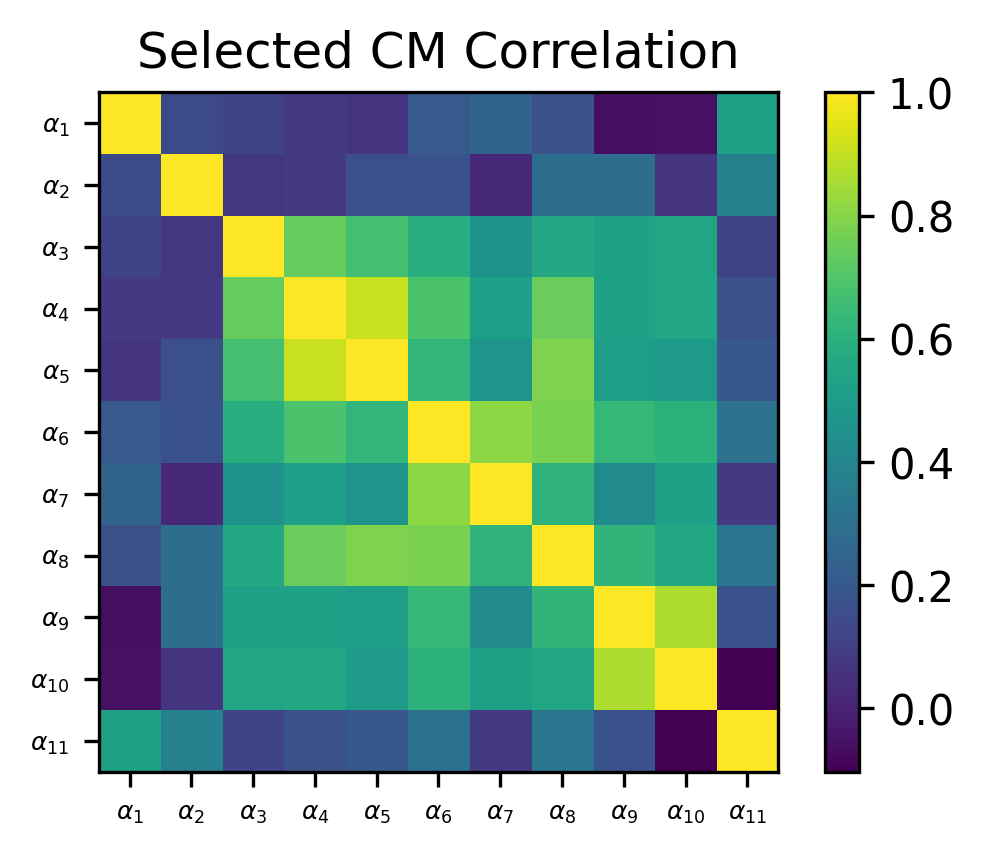

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-15",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}
Selected 35 Regions: f['AD', 'AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'MX', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SG', 'SI', 'SK']


In [49]:
regions = ['AT', 'BA', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'NL', 'PL', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK']
# Same, outside Europe
regions += ['AD', 'CN-HK', 'EG', 'IL', 'JP', 'KR', 'MX', 'SG']


features = ['Masks over 60',
 'Asymptomatic contact isolation',
 'Gatherings limited to 10',
 'Gatherings limited to 100',
 'Gatherings limited to 1000',
 'Business suspended - some',
 'Business suspended - many',
 'Schools and universities closed',
 'General curfew - permissive',
 'General curfew - strict',
 'Healthcare specialisation over 0.2']

dp = DataPreprocessor(end_date="2020-04-15")
data = dp.preprocess_data("../../data", regions, features)

In [58]:
unique_packages = []
countries_present_in = []
days_present = []

nRs, nCMs, nDs = data.ActiveCMs.shape

for r in range(nRs):
    for d in range(nDs):
        package = tuple(np.nonzero(data.ActiveCMs[r, :, d])[0])
        if package not in unique_packages:
            unique_packages.append(package)
            countries_present_in.append([r])
            days_present.append(1)
        else:
            i = unique_packages.index(package)
            if r not in countries_present_in[i]:
                countries_present_in[i].append(r)
            days_present[i] = days_present[i] + 1
            
package_info = list(zip(unique_packages, countries_present_in, days_present))
package_info.sort(key = lambda pkg: pkg[2], reverse=True)


print(f"Possible Unique Packages with {nCMs} features is {2**nCMs}")
print(f"Dataset contains {len(unique_packages)} unique packages")
print()

for pkg, countries, ndays in package_info:
    print(f"Package ({ndays} days, {len(countries)} countries):\n") 
    for p in pkg:
        print(f"  {data.CMs[p]}")
    print()

Possible Unique Packages with 11 features is 2048
Dataset contains 58 unique packages

Package (901 days, 32 countries):


Package (149 days, 6 countries):

  Gatherings limited to 10
  Gatherings limited to 100
  Gatherings limited to 1000
  Business suspended - some
  Business suspended - many
  Schools and universities closed
  General curfew - permissive
  General curfew - strict

Package (100 days, 5 countries):

  Asymptomatic contact isolation

Package (100 days, 5 countries):

  Gatherings limited to 10
  Gatherings limited to 100
  Gatherings limited to 1000
  Business suspended - some
  Business suspended - many
  Schools and universities closed

Package (90 days, 8 countries):

  Gatherings limited to 100
  Gatherings limited to 1000
  Schools and universities closed

Package (76 days, 3 countries):

  Gatherings limited to 10
  Gatherings limited to 100
  Gatherings limited to 1000
  Business suspended - some
  Schools and universities closed
  General curfew - permissive
 

In [59]:
with cm_effect.models.CMModelFlexibleV3p1(data) as model:
    model.build_cm_reduction_exp_gamma_prior()
    model.build_region_growth_prior()
    model.build_region_reliability_prior(pm.Normal, {"mu": 1, "sigma": 0.05})
    model.build_rates()
    model.build_output_model()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed_log contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


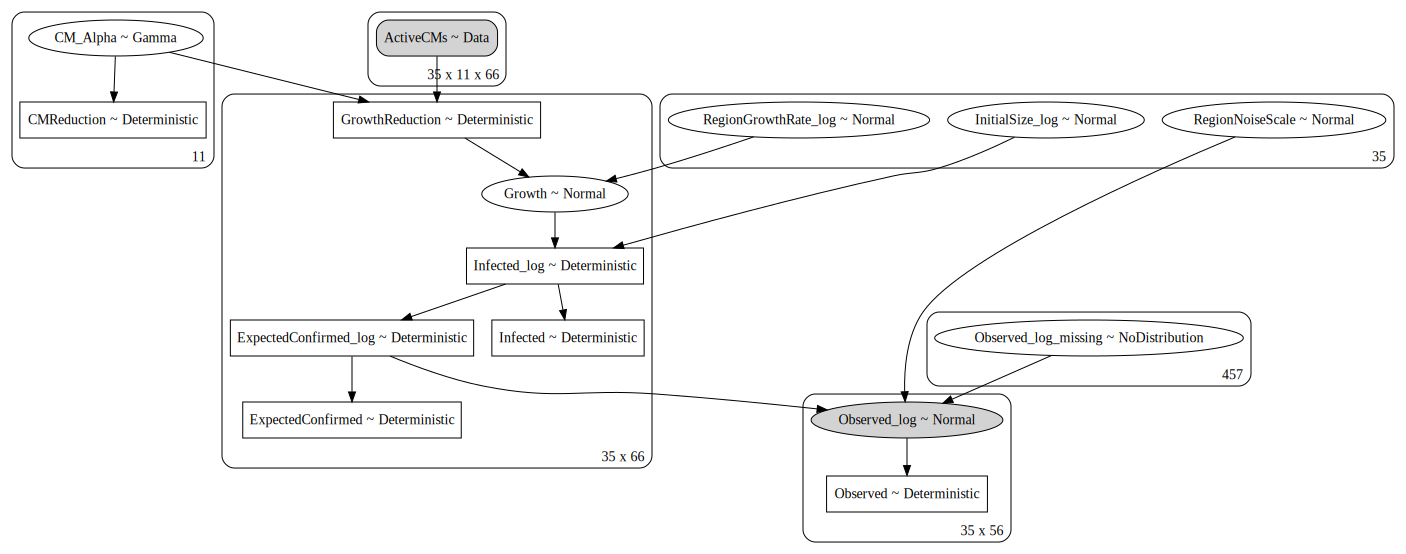

In [60]:
pm.model_to_graphviz(model).render("modelV3")
pm.model_to_graphviz(model)

In [61]:
model.run(2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CM_Alpha_log__              -15.61
RegionGrowthRate_log          9.98
RegionNoiseScale             72.69
Growth                     3196.22
InitialSize_log            -112.75
Observed_log_missing          0.00
Observed_log           -8471768.97
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
INFO:pymc3:NUTS: [Observed_log_missing, InitialSize_log, Growth, RegionNoiseScale, RegionGrowthRate_log, CM_Alpha]
Sampling 2 chains, 14 divergences: 100%|██████████| 5000/5000 [06:38<00:00, 12.55draws/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


INFO:epimodel.pymc3_models.cm_effect.models:Saving Plot at /Users/mrinank/workspace/epidemicforecasting/epimodel/notebooks/heldout_validation/out


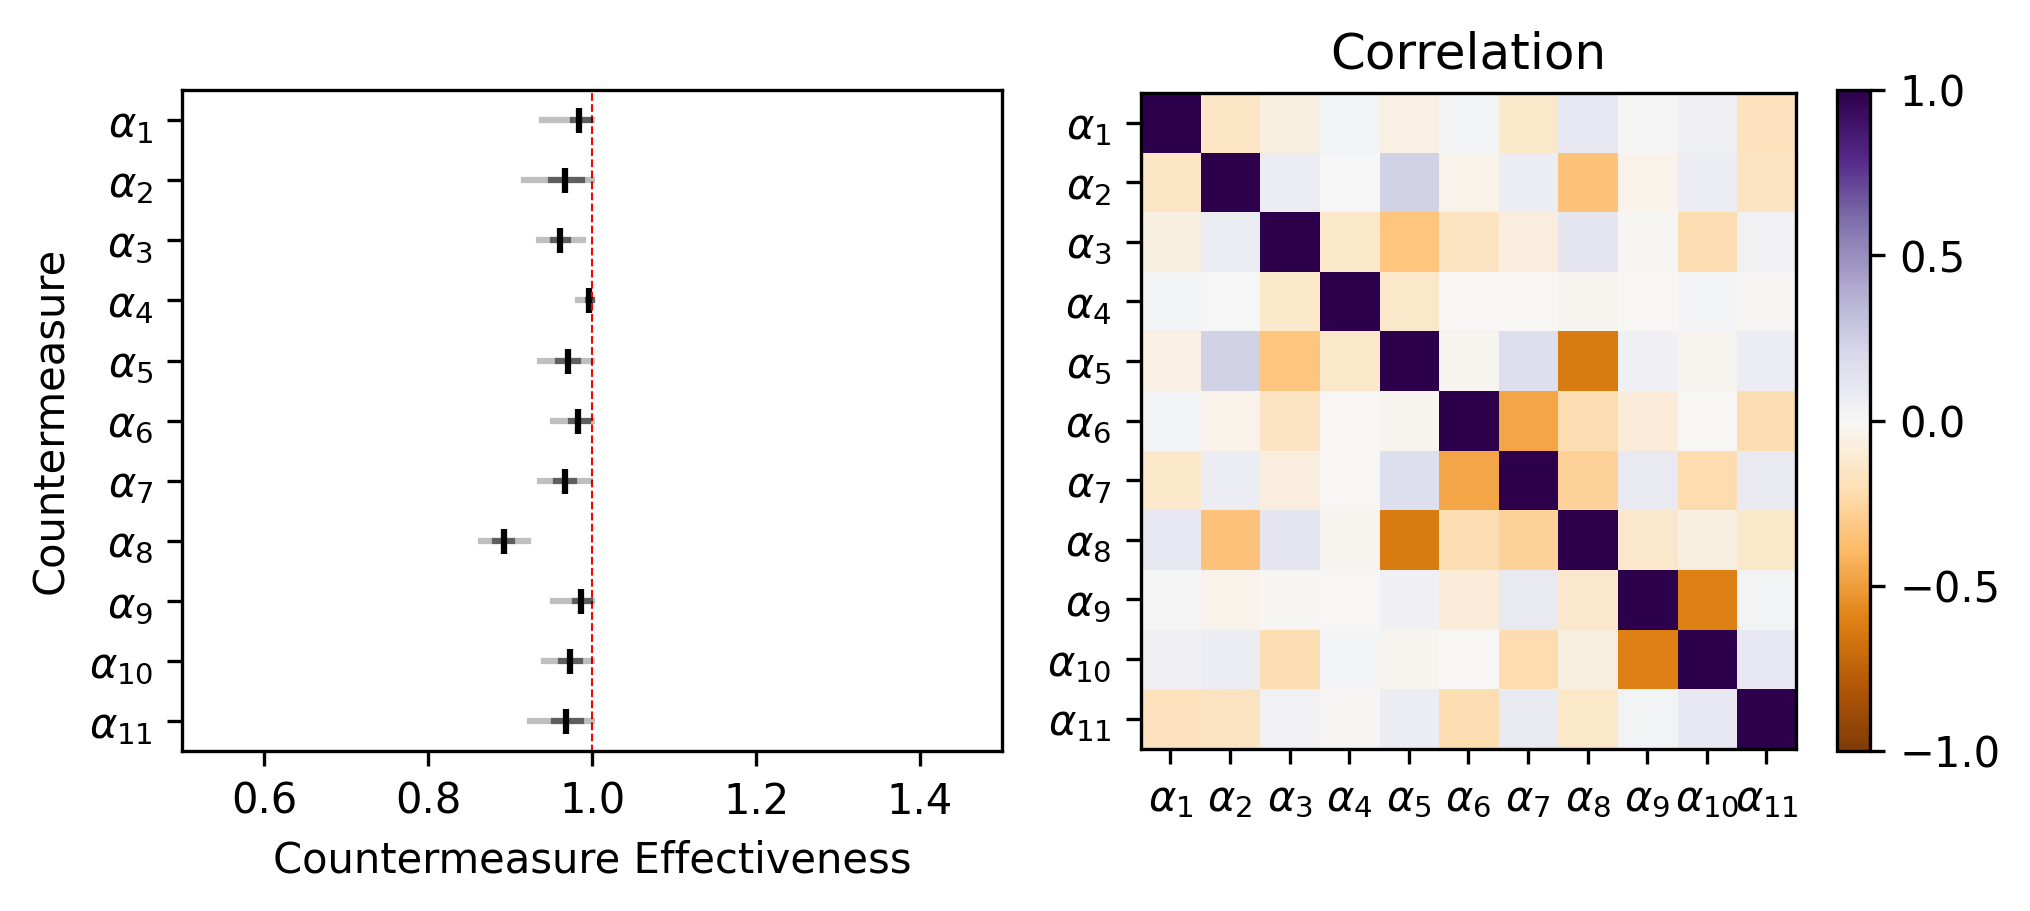

In [62]:
model.plot_effect()

# plot "package" posteriors

In [81]:
nPkgs = len(package_info)

N_samples, _ = model.trace["CMReduction"].shape

# form product package trace
pkg_trace = np.zeros((N_samples, nPkgs))
for pkg in range(nPkgs):
    cms = package_info[pkg][0]
    package_full_trace = model.trace["CMReduction"][:, cms]
    pkg_trace[:, pkg] = np.prod(package_full_trace, axis=1) 

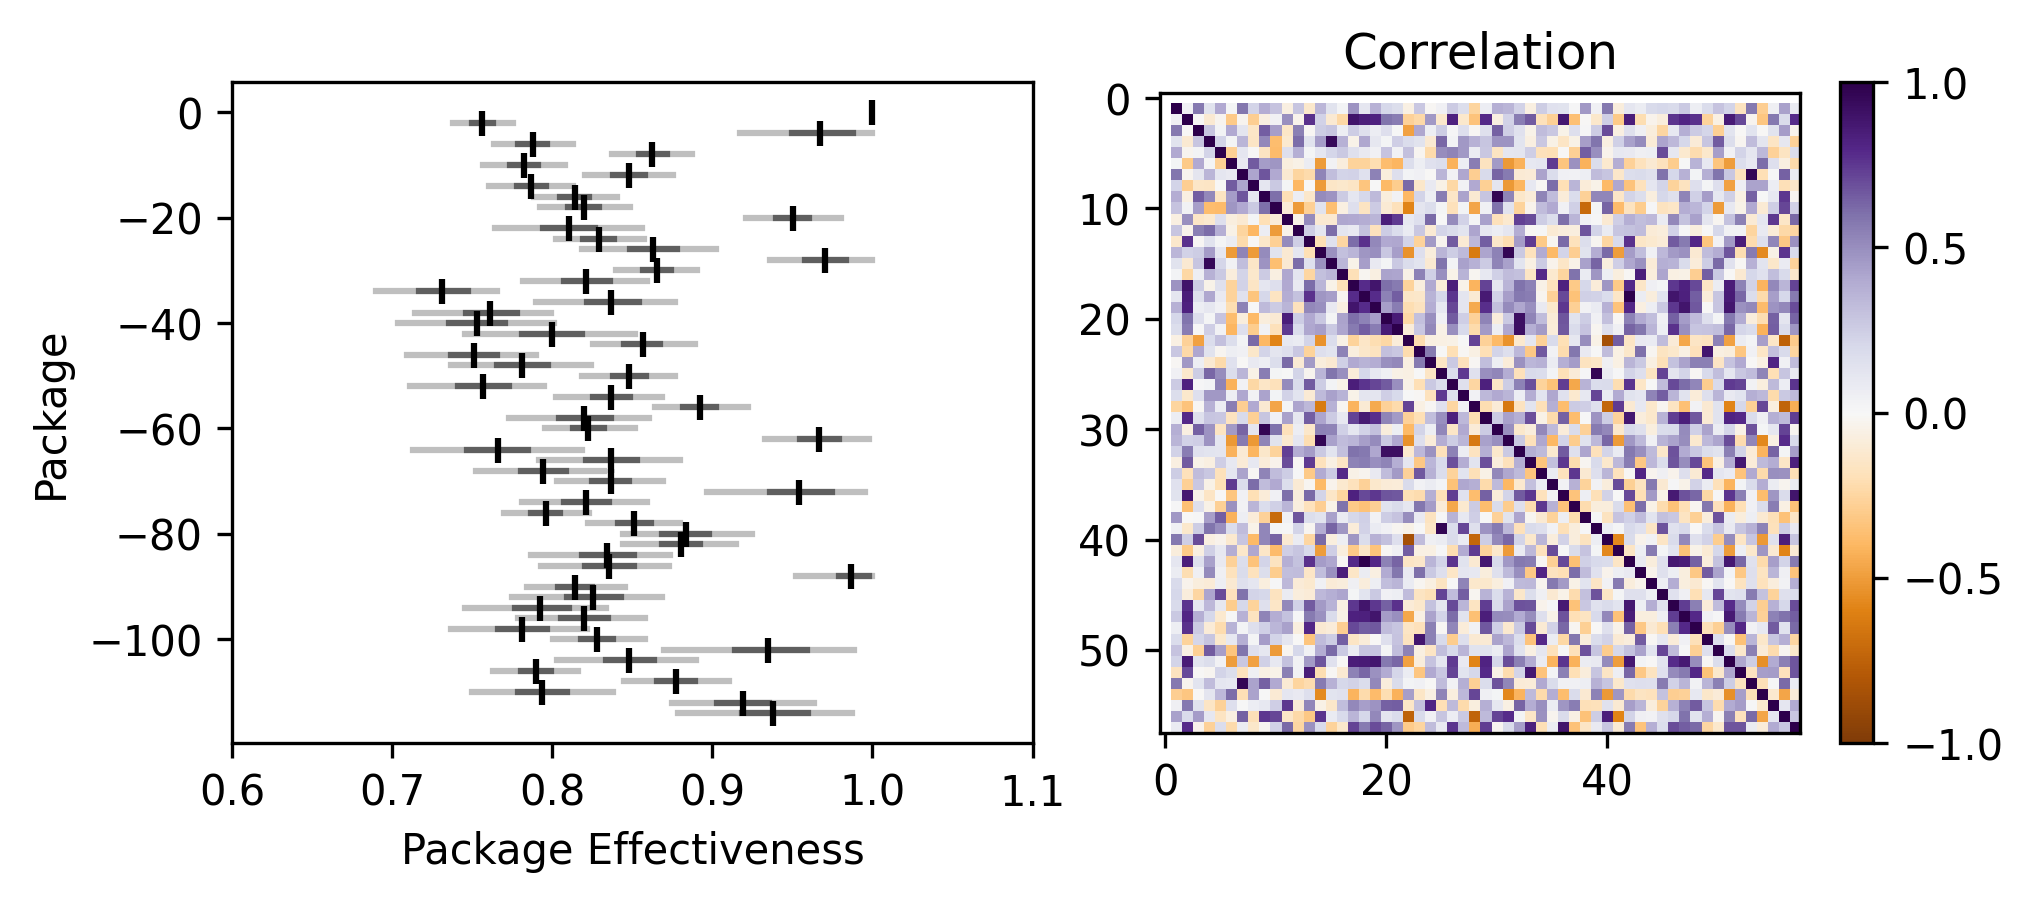

In [92]:
fig = plt.figure(figsize=(7, 3), dpi=300)
means = np.mean(pkg_trace, axis=0)
li = np.percentile(pkg_trace, 2.5, axis=0)
ui = np.percentile(pkg_trace, 97.5, axis=0)
lq = np.percentile(pkg_trace, 25, axis=0)
uq = np.percentile(pkg_trace, 75, axis=0)

N_cms = means.size

plt.subplot(121)
#plt.plot([1, 1], [1, -(N_cms)], "--r", linewidth=0.5)
y_vals = -2 * np.arange(N_cms)
plt.scatter(means, y_vals, marker="|", color='k')
for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.25)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.5)

plt.xlim([0.6, 1.1])
plt.ylabel("Package", rotation=90)
#plt.yticks(y_vals, [f"$\\alpha_{{{i + 1}}}$" for i in range(N_cms)])
plt.xlabel("Package Effectiveness")

plt.subplot(122)
correlation = np.corrcoef(pkg_trace, rowvar=False)
plt.imshow(correlation, cmap="PuOr", vmin=-1, vmax=1)
plt.colorbar()
plt.title("Correlation")

plt.tight_layout()

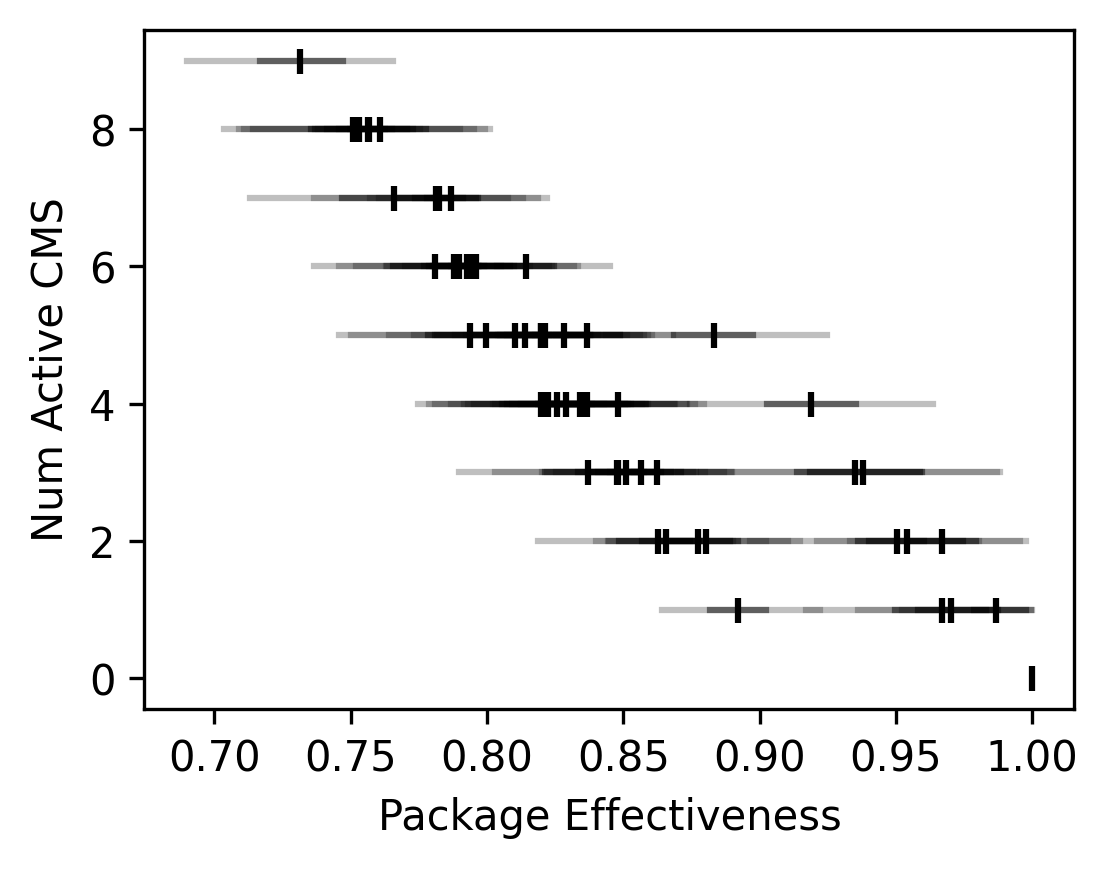

In [97]:
plt.figure(figsize=(4,3), dpi=300)

y_vals = [len(pkg[0]) for pkg in package_info]
plt.scatter(means, y_vals, marker="|", color='k')
for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.25)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "k", alpha=0.5)

plt.ylabel("Num Active CMS")
plt.xlabel("Package Effectiveness");

From this, it seems worth noting that

* we have the trend we'd expect - the mode active CMS we have together, the more effective the package is.
* There do seem to be outliers in the above analysis. 

Let's split this up a bit more, now:

* comparing different packages of the same size
* comparing the best packages of different size. 

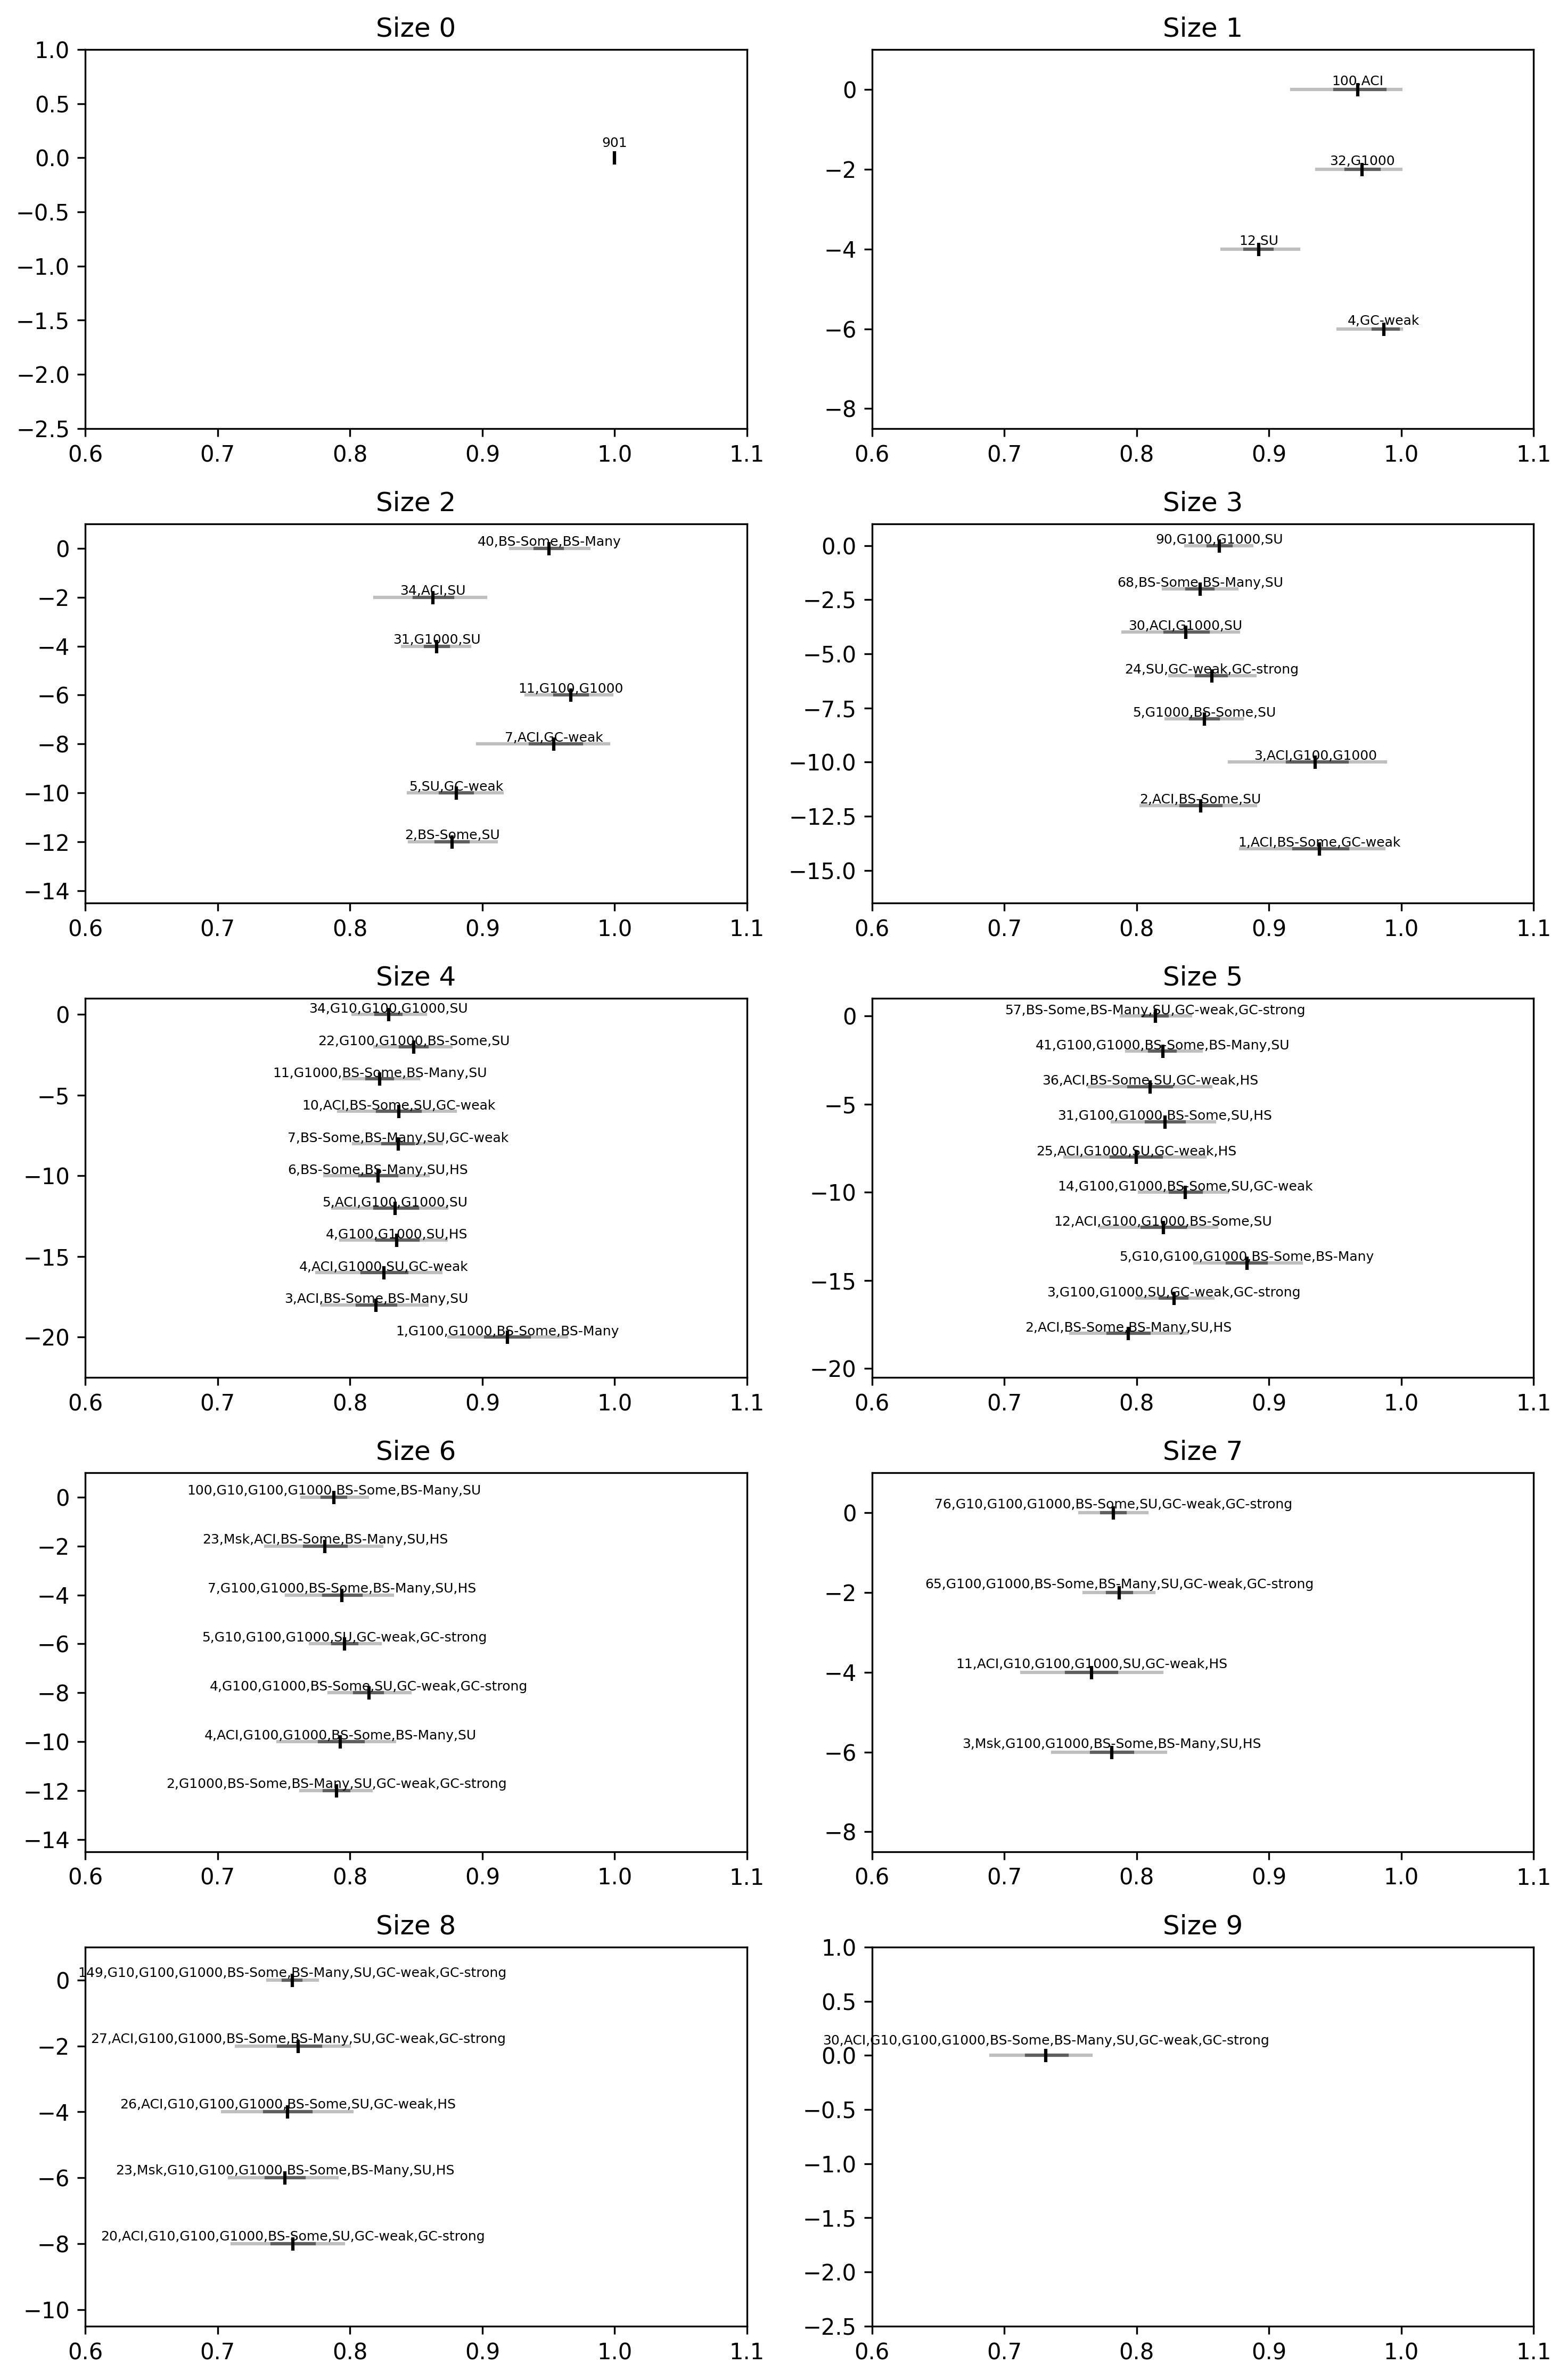

In [120]:
feature_labels = ['Msk',
 'ACI',
 'G10',
 'G100',
 'G1000',
 'BS-Some',
 'BS-Many',
 'SU',
 'GC-weak',
 'GC-strong',
 'HS']


plt.figure(figsize=(10,15), dpi=300)
for sz in range(0, 10):
    plt.subplot(5, 2, sz+1)
    y_val = 0
    for cm in range(N_cms):
        if len(package_info[cm][0]) == sz:
            plt.scatter(means[cm], [y_val], marker="|", color='k')
            plt.plot([li[cm], ui[cm]], [y_val, y_val], "k", alpha=0.25)
            plt.plot([lq[cm], uq[cm]], [y_val, y_val], "k", alpha=0.5)
            
            text = f"{package_info[cm][2]}"
            for acm in package_info[cm][0]:
                text +=f",{feature_labels[acm]}"
                
            plt.text(means[cm], y_val+0.1, text, fontsize=6, horizontalalignment="center")
            y_val -= 2
        plt.xlim([0.6, 1.1])
        plt.ylim([y_val-0.5, 1])
        plt.title(f"Size {sz}")
        
plt.tight_layout()

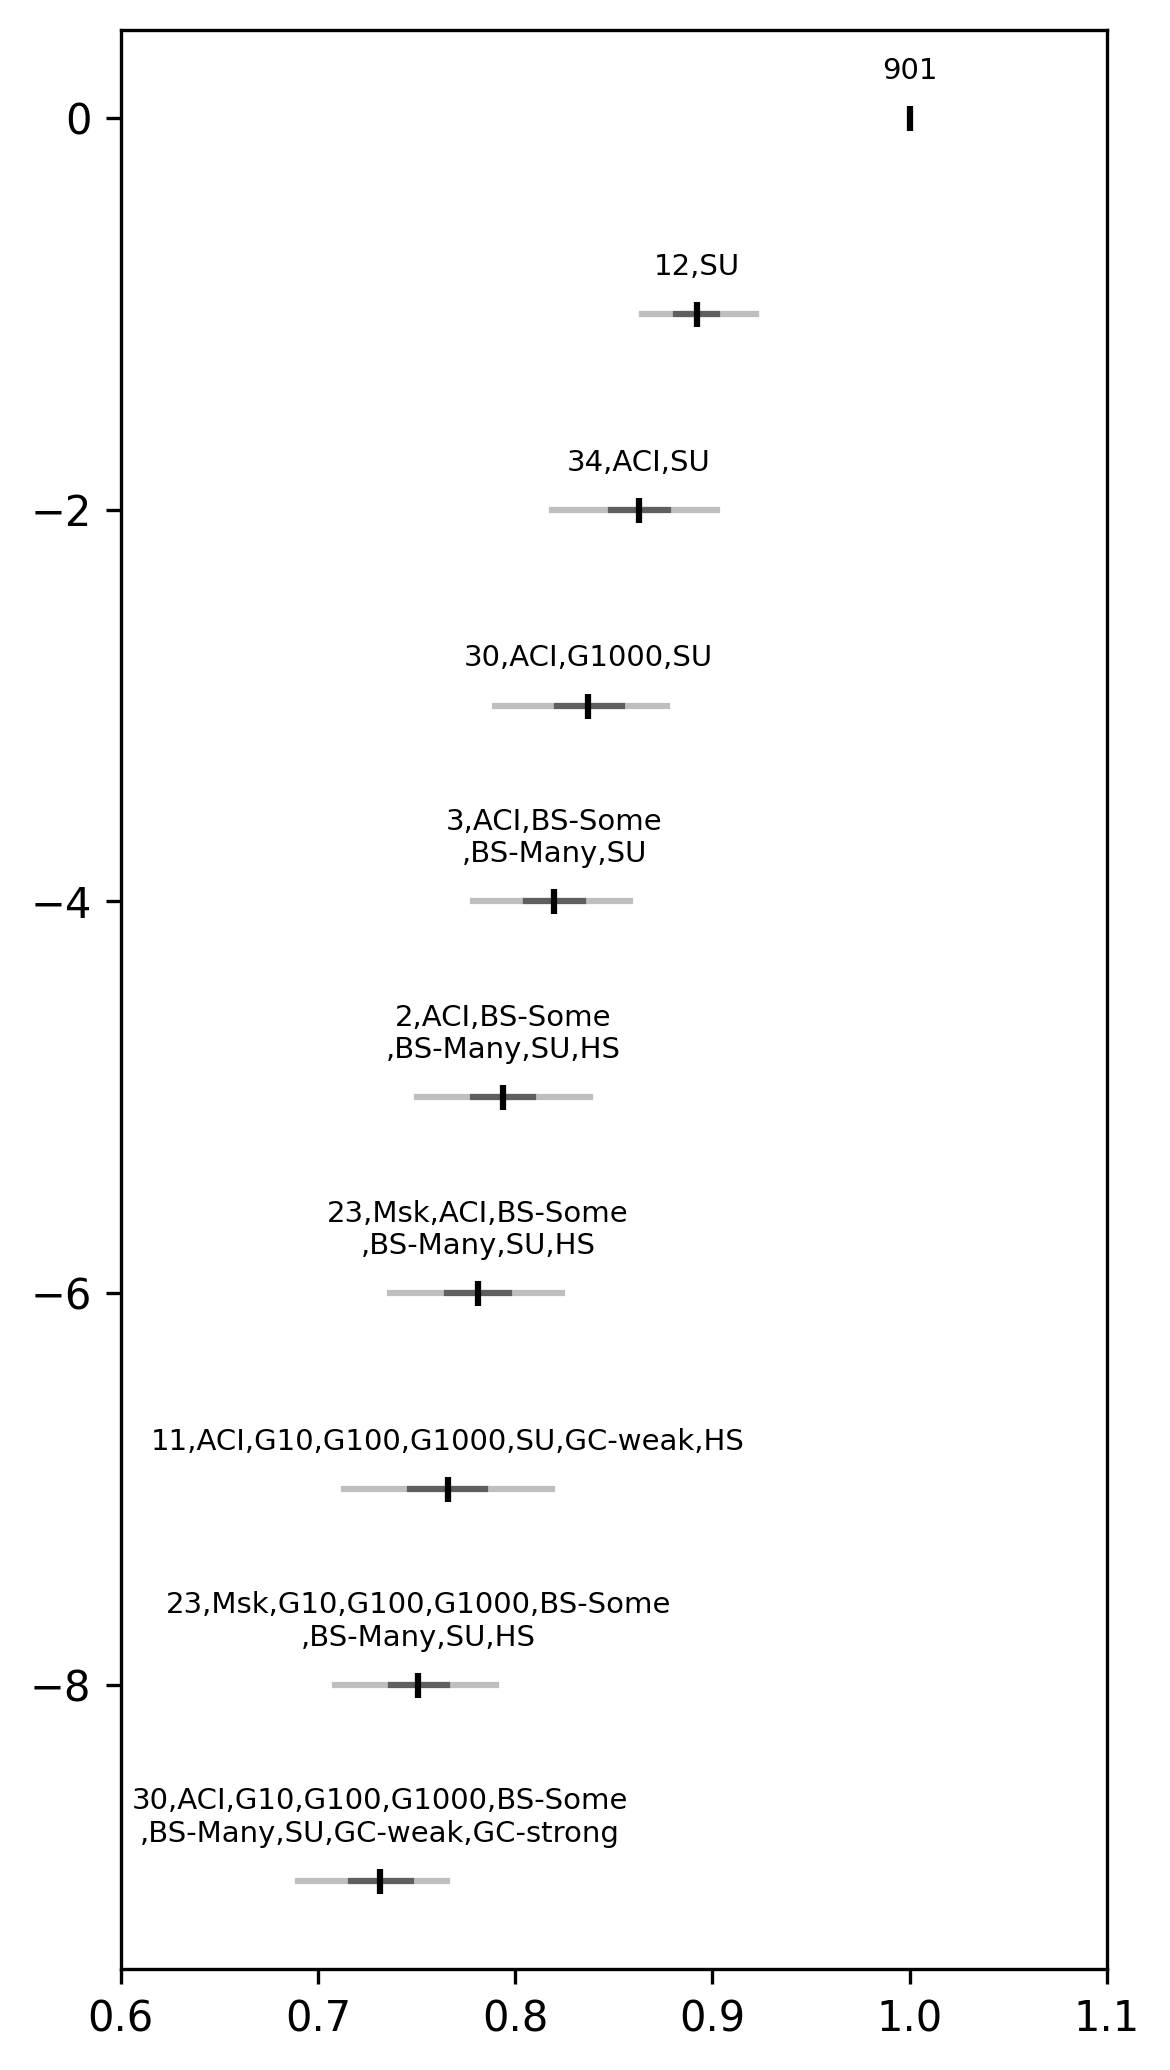

In [127]:
plt.figure(figsize=(4,7), dpi=300)
y_val = 0
for sz in range(0, 10):
    score = 1.5
    best_indx = 9
    for cm in range(N_cms):
        if len(package_info[cm][0]) == sz:
            if means[cm] < score:
                score = means[cm]
                best_indx = cm
    
    plt.scatter(means[best_indx], [y_val], marker="|", color='k')
    plt.plot([li[best_indx], ui[best_indx]], [y_val, y_val], "k", alpha=0.25)
    plt.plot([lq[best_indx], uq[best_indx]], [y_val, y_val], "k", alpha=0.5)

    text = f"{package_info[best_indx][2]}"
    for acm in package_info[best_indx][0]:
        if acm == 5:
            text +=f",{feature_labels[acm]}\n"
        else:
            text +=f",{feature_labels[acm]}"

    plt.text(means[best_indx], y_val+0.2, text, fontsize=7, horizontalalignment="center")
    y_val -= 1
    
plt.xlim([0.6, 1.1])
        
plt.tight_layout()